# <font color='blue'>Data Science Academy - Machine Learning</font>

# <font color='blue'>Capítulo 15</font>

In [ ]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

## Mini-Projeto 7

## Sistema de Recomendação de Filmes da Netflix

![title](imagens/mini-projeto7.png)

## Definição do Problema

<p>
O objetivo da Netflix é conectar as pessoas aos filmes que elas adoram. Para ajudar os clientes a encontrar esses filmes, eles desenvolveram um sistema de recomendação de filmes de classe mundial: CinematchSM. Seu trabalho é prever se alguém vai gostar de um filme com base no quanto gostou ou não de outros filmes. A Netflix usa essas previsões para fazer recomendações pessoais de filmes com base nos gostos exclusivos de cada cliente. E embora o <b> Cinematch </b> esteja indo muito bem, sempre pode ser melhorado.
</p>
<p> Existem várias abordagens alternativas interessantes de como o Cinematch funciona que o netflix ainda não experimentou. Alguns são descritos na literatura, outros não. Estamos curiosos para saber se algum deles pode vencer o Cinematch fazendo previsões melhores. Porque, francamente, se houver uma abordagem muito melhor, isso pode fazer uma grande diferença para nossos clientes e nossos negócios. </p>

Objetivos:

1. Prever a avaliação que um usuário daria a um filme que ainda não avaliou.
2. Minimizar a diferença entre a avaliação prevista e real (RMSE e MAPE).

Restrições:

1. Alguma forma de interpretabilidade.

## Fonte de Dados

<p>
A Netflix forneceu muitos dados de classificação anônimos e uma barra de precisão de predição que é 10% melhor do que o que o Cinematch pode fazer no mesmo conjunto de dados de treinamento. A precisão é uma medida de quão próximo as classificações previstas dos filmes correspondem às classificações reais subsequentes.
</p>

<ul>
<li> <a href="https://www.netflixprize.com/rules.html">Netflix Prize</a></li>
<li> <a href="https://www.kaggle.com/netflix-inc/netflix-prize-data">Dataset</a></li>

## Instalando e Carregando os Pacotes

In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

In [ ]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

# Formatação dos gráficos
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

In [ ]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

## Carregando os Dados

Para carregar os dados vamos executar as seguintes operações:

- 1- Fazer a leitura das linhas de todos os arquivos disponíveis.
- 2- Combinar todas as linhas de todos os arquivos em um único arquivo.
- 3- Carregar o arquivo gerado em um dataframe do pandas.

In [ ]:
# Marca o início da execução de leitura dos arquivos.
start = datetime.now()

In [ ]:
# Criaremos um arquivo final chamado dados.csv

# Se o arquivo não existir, criamos o arquivo em modo de escrita (w)
if not os.path.isfile('dados/dados.csv'):
    
    # Cria e abre o arquivo para gravação
    dataset = open('dados/dados.csv', mode = 'w')
    
    # Lista para as linhas dos arquivos
    linhas = list()
    
    # Nomes e caminhos dos arquivos
    arquivos = ['dados/combined_data_1.txt',
                'dados/combined_data_2.txt', 
                'dados/combined_data_3.txt', 
                'dados/combined_data_4.txt']
    
    # Loop por cada arquivo na lista de arquivos
    for arquivo in arquivos:
        
        # Print
        print("Lendo o arquivo {}...".format(arquivo))
        
        # Com o arquivo aberto, extraímos as linhas
        with open(arquivo) as f:
            
            # Loop por cada linha do arquivo
            for linha in f: 
                
                # Deletamos o conteúdo da lista
                del linhas[:] 
                
                # Divide as linhas do arquivo pelo caracter de final de linha
                linha = linha.strip()
                
                # Se encontramos "dois pontos" ao final da linha, fazemos replace removendo o caracter,
                # pois queremos apenas o id do filme
                if linha.endswith(':'):
                    movie_id = linha.replace(':', '')
                    
                # Se não, criamos uma lista comprehension para fazer a separação das colunas por vírgula
                else:
                    
                    # Separa as colunas
                    linhas = [x for x in linha.split(',')]
                    
                    # Usa o id do filme na posição de índice zero
                    linhas.insert(0, movie_id)
                    
                    # Grava o resultado no novo arquivo
                    dataset.write(','.join(linhas))
                    dataset.write('\n')
                    
        print("Concluído.\n")
        
    dataset.close()

In [ ]:
# Imprime o tempop total
print('Tempo Total Para Carregar os Arquivos:', datetime.now() - start)

In [ ]:
%%time
print("Criando o dataframe pandas a partir do arquivo dados.csv...")
df_netflix = pd.read_csv('dados/dados.csv', sep = ',', names = ['movie', 'user', 'rating', 'date'])
df_netflix.date = pd.to_datetime(df_netflix.date)
print('Concluído.')

In [ ]:
%%time
# Ordenando o dataframe por data
print('Ordenando o dataframe por data..')
df_netflix.sort_values(by = 'date', inplace = True)
print('Concluído.')

In [ ]:
# Shape
df_netflix.shape

In [ ]:
# Visualizando os dados
df_netflix.head()

Trabalhar com 100 Milhões de Registros não é fácil e isso pode consumir muitos recursos computacionais. Algumas dicas:

- 1- Feche todos os arquivos e softwares no seu computador. Deixe apenas o que for realmente necessário.
- 2- Considere o uso de um ambiente em nuvem ou mesmo cluster de computadores, se possível.
- 3- Reduza o tamanho de cada arquivo. Aqui algumas sugestões de softwares "File Splitter":

http://www.fastfilejoiner.com/

https://www.gdgsoft.com/gsplit/download

http://www.kcsoftwares.com/?kfk

## Análise Exploratória dos Dados

In [ ]:
%%time
# Resumo dos dados
print("Resumo dos Dados")
print("-"*50)
print("Número Total de Filmes:", len(np.unique(df_netflix.movie)))
print("Número Total de Usuários:", len(np.unique(df_netflix.user)))
print("Número Total de Avaliações:", df_netflix.shape[0])

In [ ]:
%%time
# Vamos salvar esses dois valores para usar mais tarde
total_users = len(np.unique(df_netflix.user))
total_movies = len(np.unique(df_netflix.movie))

In [ ]:
# Verificando a média das avaliações
df_netflix.describe()['rating']

In [ ]:
# Verificando se temos valores ausentes
sum(df_netflix.isnull().any())

In [ ]:
# Verificando se temos valores duplicados (para esse caso não consideramos a data)
sum(df_netflix.duplicated(['movie', 'user', 'rating']))

Vamos dividir os dados em treino e teste antes de continuar como a análise exploratória, pois algumas análises só fazem sentido para os dados de treino. Usaremos a proporção 80/20 para treino/teste.

In [ ]:
%%time
# Criaremos um dataset em disco com os dados de treino
# Dessa forma não precisamos executar todo o processo de carga novamente cada vez que executar este notebook
if not os.path.isfile('dados/dados_treino.csv'):
    df_netflix.iloc[:int(df_netflix.shape[0] * 0.80)].to_csv("dados/dados_treino.csv", index = False)

In [ ]:
%%time
# Criaremos um dataset em disco com os dados de teste
# Dessa forma não precisamos executar todo o processo de carga novamente cada vez que executar este notebook
if not os.path.isfile('dados/dados_teste.csv'):
    df_netflix.iloc[int(df_netflix.shape[0] * 0.80):].to_csv("dados/dados_teste.csv", index = False)

In [ ]:
# Deletamos o dataframe original para liberar memória
del df_netflix

Quando executar este Jupyter Notebook novamente, pode iniciar a partir desta célula abaixo (após carregar os pacotes).

Caso tenha erro no Jupyter Noteboook, faça um refresh na aba com http://localhost:8888/tree.

In [3]:
%%time
# Agora carregamos os arquivos em dataframes do pandas
df_netflix_treino = pd.read_csv("dados/dados_treino.csv", parse_dates = ['date'])
df_netflix_teste = pd.read_csv("dados/dados_teste.csv")

CPU times: user 45.7 s, sys: 8.42 s, total: 54.1 s
Wall time: 1min 36s


In [4]:
# Resumo dos dados de treino
print("Resumo dos Dados de Treino")
print("-"*50)
print("Número Total de Filmes:", len(np.unique(df_netflix_treino.movie)))
print("Número Total de Usuários:", len(np.unique(df_netflix_treino.user)))
print("Número Total de Avaliações:", df_netflix_treino.shape[0])

Resumo dos Dados de Treino
--------------------------------------------------
Número Total de Filmes: 17424
Número Total de Usuários: 405041
Número Total de Avaliações: 80384405


In [5]:
# Resumo dos dados de teste
print("Resumo dos Dados de Teste")
print("-"*50)
print("Número Total de Filmes:", len(np.unique(df_netflix_teste.movie)))
print("Número Total de Usuários:", len(np.unique(df_netflix_teste.user)))
print("Número Total de Avaliações:", df_netflix_teste.shape[0])

Resumo dos Dados de Teste
--------------------------------------------------
Número Total de Filmes: 17757
Número Total de Usuários: 349312
Número Total de Avaliações: 20096102


A função abaixo vai ajustar as medidas em milhares, milhões e bilhões para facilitar a leitura dos gráficos.

In [4]:
# Função para ajuste das unidades de medida
def ajusta_unidades(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [5]:
# Supress warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

__Vamos verificar a distribuição das avaliações.__

<IPython.core.display.Javascript object>


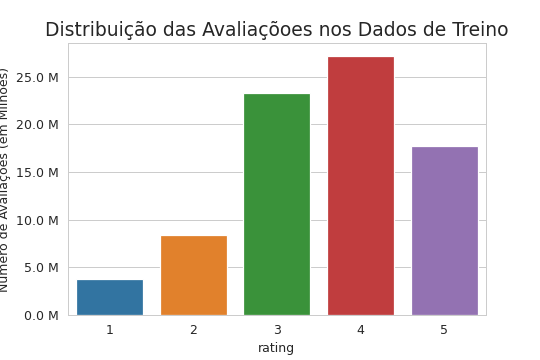

In [8]:
# Plot
fig, ax = plt.subplots()
plt.title('Distribuição das Avaliaçõoes nos Dados de Treino', fontsize = 15)
sns.countplot(df_netflix_treino.rating)
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Número de Avaliações (em Milhões)')
plt.show()

__Será que o dia da semana tem influencia na avaliação do usuário? Vamos incluir uma coluna com o dia da semana e descobrir.__

In [9]:
# Parâmetro para evitar warning devido ao alto volume de dados
pd.options.mode.chained_assignment = None  

In [6]:
# Extrai o dia da semana e grava em uma nova coluna
df_netflix_treino['dia_semana'] = df_netflix_treino['date'].dt.strftime("%A")
df_netflix_treino.head()

,movie,user,rating,date,dia_semana
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


In [ ]:
# Plot
fig, ax = plt.subplots()
sns.countplot(x = 'dia_semana', data = df_netflix_treino, ax = ax)
plt.title('Número de Avaliações Por Dia da Semana')
plt.ylabel('Total de Avaliações')
plt.xlabel('')
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
plt.show()

<IPython.core.display.Javascript object>

__Vamos calcular a média de avaliações por dia da semana.__

In [ ]:
# Média de avaliações por dia da semana
media_dia_semana = df_netflix_treino.groupby(by = ['dia_semana'])['rating'].mean()
print("Média de Avaliações")
print("-"*30)
print(media_dia_semana)
print("\n")

O dia da semana não parecer ter influência na avaliação dos usuários.

__Vamos analisar as avaliações dos usuários ao longo do tempo.__

In [ ]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax = df_netflix_treino.resample('m', on = 'date')['rating'].count().plot()
ax.set_title('Número de Avaliações Por Mês nos Dados de Treino')
plt.xlabel('Mês')
plt.ylabel('Número de Avaliações Por Mês)')
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
plt.show()

Claramente há um aumento nas avaliações dos usuários ao longo do tempo, devido ao maior número de usuários ou porque os usuários aprenderam a usar o recurso.

__Vamos verificar os usuários que mais fizeram avaliações de filmes.__

In [7]:
# Número de avaliações por usuário
num_aval_por_user = df_netflix_treino.groupby(by = 'user')['rating'].count().sort_values(ascending = False)
num_aval_por_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

In [8]:
# Resumo estatístico
num_aval_por_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

__Vamos criar um plot da função de função de densidade de probabilidade e da função de distribuição acumulada.__

A função de densidade de probabilidade (pdf) e função de distribuição acumulada (cdf) são duas das funções estatísticas mais importantes em confiabilidade e estão intimamente relacionadas. Quando essas funções são conhecidas, quase qualquer outra medida de confiabilidade de interesse pode ser derivada ou obtida. Mais sobre isso aqui:

http://reliawiki.org/index.php/Basic_Statistical_Background

<IPython.core.display.Javascript object>


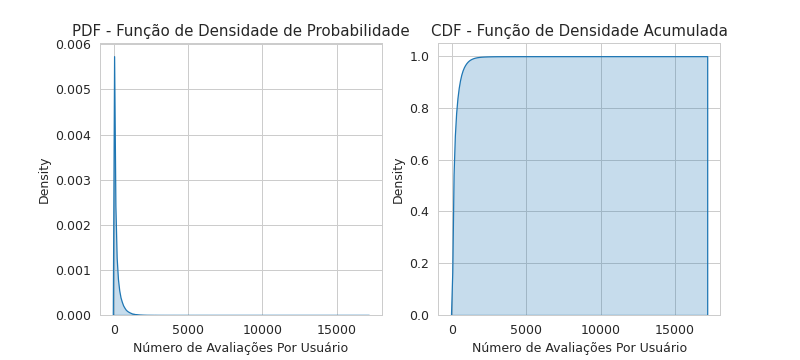

In [9]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax1 = plt.subplot(121)
sns.kdeplot(num_aval_por_user, shade = True, ax = ax1)
plt.xlabel('Número de Avaliações Por Usuário')
plt.title("PDF - Função de Densidade de Probabilidade")
ax2 = plt.subplot(122)
sns.kdeplot(num_aval_por_user, shade = True, cumulative = True, ax = ax2)
plt.xlabel('Número de Avaliações Por Usuário')
plt.title('CDF - Função de Densidade Acumulada')
plt.show()

Observe que a grande maioria dos usuários tem menos de 1000 avaliações.

__Quantas avaliações estão nos últimos 5% de todas as avaliações??__

In [10]:
# Vamos extrair os percentis
percentis = num_aval_por_user.quantile(np.arange(0,1.01,0.01), interpolation = 'higher')

In [11]:
# Visualizando de 5 em 5
percentis[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


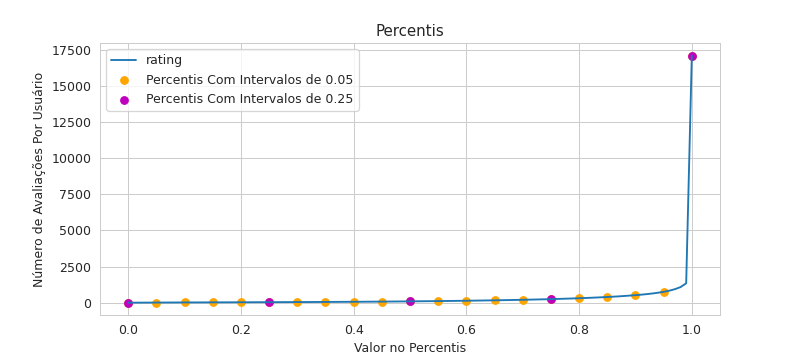

TypeError: annotate() missing 1 required positional argument: 'text'

In [12]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.title("Percentis")
percentis.plot()

# Quartis com diferença de 0.05
plt.scatter(x = percentis.index[::5], 
            y = percentis.values[::5], 
            c = 'orange', 
            label = "Percentis Com Intervalos de 0.05")

# Quartis com diferença de 0.25
plt.scatter(x = percentis.index[::25], 
            y = percentis.values[::25], 
            c = 'm', 
            label = "Percentis Com Intervalos de 0.25")

# Labels e legenda
plt.ylabel('Número de Avaliações Por Usuário')
plt.xlabel('Valor no Percentis')
plt.legend(loc = 'best')

# Vamos marcar os percentis 25, 50, 75 e 100
for x,y in zip(percentis.index[::25], percentis[::25]):
    plt.annotate(s = "({} , {})".format(x,y), xy = (x,y), xytext = (x-0.05, y+500), fontweight = 'bold')

plt.show()

- Existem alguns filmes (que são muito populares) que são avaliados por um grande número de usuários.
    
- Mas a maioria dos filmes (como 90%) tem algumas centenas de avaliações.

## Criação de Matriz Esparsa

![title](imagens/Sparse_Matrix.png)

![title](imagens/Matriz_Esparsa.png)

### Criação da Matriz Esparsa de Treino

In [ ]:
# Criamos a matriz esparsa no formato Numpy caso não exista
# Se existir, apenas carregamos a partir do disco
if os.path.isfile('dados/matriz_esparsa_treino.npz'):
    matriz_esparsa_treino = sparse.load_npz('dados/matriz_esparsa_treino.npz')
    print("Matriz Carregada.")
else: 
    matriz_esparsa_treino = sparse.csr_matrix((df_netflix_treino.rating.values, (df_netflix_treino.user.values, 
                                                                                 df_netflix_treino.movie.values)),)
    print('Matriz Criada. O shape é: (user, movie): ', matriz_esparsa_treino.shape)
    sparse.save_npz("dados/matriz_esparsa_treino.npz", matriz_esparsa_treino)
    print('Matriz Salva em Disco.')

Matriz Criada. O shape é: (user, movie):  (2649430, 17771)


In [ ]:
# Calculamos a esparsidade da matriz
linhas, colunas = matriz_esparsa_treino.shape
elementos_nao_zero = matriz_esparsa_treino.count_nonzero()
print("Esparsidade da Matriz de Treino: {} % ".format(  (1 - (elementos_nao_zero / (linhas * colunas))) * 100) )

### Criação da Matriz Esparsa de Teste

In [ ]:
# Criamos a matriz esparsa no formato Numpy caso não exista
# Se existir, apenas carregamos a partir do disco
if os.path.isfile('dados/matriz_esparsa_teste.npz'):
    matriz_esparsa_teste = sparse.load_npz('dados/matriz_esparsa_teste.npz')
    print("Matriz Carregada.")
else: 
    matriz_esparsa_teste = sparse.csr_matrix((df_netflix_teste.rating.values, (df_netflix_teste.user.values, 
                                                                               df_netflix_teste.movie.values)))
    
    print('Matriz Criada. O shape é: (user, movie): ', matriz_esparsa_teste.shape)
    sparse.save_npz("dados/matriz_esparsa_teste.npz", matriz_esparsa_teste)
    print('Matriz Salva em Disco.')

In [ ]:
# Calculamos a esparsidade da matriz
linhas, colunas = matriz_esparsa_teste.shape
elementos_nao_zero = matriz_esparsa_teste.count_nonzero()
print("Esparsidade da Matriz de Teste: {} % ".format(  (1 - (elementos_nao_zero / (linhas * colunas))) * 100) )

__Vamos calcular a média global de todas as avaliações de filmes, avaliação média por usuário e avaliação média por filme.__

In [ ]:
# Abaixo calculamos a média global de todas as avaliações de usuários.
medias_treino = dict()
medias_treino_global = matriz_esparsa_treino.sum() / matriz_esparsa_treino.count_nonzero()
medias_treino['global'] = medias_treino_global
medias_treino

__Vamos construir uma função para o cálculo da média de avaliações.__

In [ ]:
# Função de cálculo da média
def calcula_media_avaliacoes(sparse_matrix, of_users):
    
    # Média de avaliações de usuários/eixos
    # 1 = eixo de usuário
    # 0 = eixo de filme
    ax = 1 if of_users else 0

    # Soma
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    # Matriz booleana de avaliações ( se um usuário avaliou um filme ou não )
    is_rated = sparse_matrix!=0
    
    # Número de avaliações de cada usuário ou filme
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # Ids máximos de usuário e filmes na matriz esparsa
    u, m = sparse_matrix.shape
    
    # Criamos um dicionário de usuários e suas avaliações médias.
    media_aval = {i:sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i]!=0}

    # Retorna o dicionário de médias de avaliações
    return media_aval

__Abaixo calculamos a média de avaliações por usuário.__

In [ ]:
# Média de avaliações de usuários
medias_treino['user'] = calcula_media_avaliacoes(matriz_esparsa_treino, of_users = True)

In [ ]:
# Visualiza o dicionário
medias_treino

In [ ]:
# Print
print('Média de Avaliação do Usuário 149 :', medias_treino['user'][149])

__Abaixo calculamos a média de avaliações por filme.__

In [ ]:
# Média de avaliações por filme
medias_treino['movie'] =  calcula_media_avaliacoes(matriz_esparsa_treino, of_users = False)

In [ ]:
# Print
print('Avaliação Média do Filme 32 :', medias_treino['movie'][32])

__PDFs e CDs da média. Avaliações de usuários e filmes (dados de treino).__

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = plt.figaspect(.45))
fig.suptitle('Médias de Avaliações Por Usuário e Por Filme', fontsize = 15)

ax1.set_title('Médias de Avaliações de Usuários')

# Obtemos a lista de avaliações médias do usuário no dicionário de médias.
medias_usuarios = [rat for rat in medias_treino['user'].values()]
sns.distplot(medias_usuarios, ax = ax1, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(medias_usuarios, ax = ax1, hist = False, label = 'PDF')

ax2.set_title('Médias de Avaliações de Filmes')

# Obtemos a lista de avaliações médias de filmes do dicionário.
medias_filmes = [rat for rat in medias_treino['movie'].values()]
sns.distplot(medias_filmes, ax = ax2, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(medias_filmes, ax = ax2, hist = False, label = 'PDF')

plt.show()

## Problema do Cold Start

In [ ]:
# Cold start de usários
usuarios_treino = len(medias_treino['user'])
novos_usuarios = total_users - usuarios_treino

In [ ]:
# Print
print('Total Geral de Usuários:', total_users)
print('Total de Usuários em Treino :', usuarios_treino)
print("Total de Usuários Que Não Estão em Treino: {} ({}%)".format(novos_usuarios,
                                                                   np.round((novos_usuarios / total_users) * 100, 2)))

75148 usuários não fazem parte dos dados de treino, ou seja, não temos como aprender o padrão de avaliação desses usuários! Esse é o problema do cold start (ou início frio).

In [ ]:
# Cold start de filmes
filmes_treino = len(medias_treino['movie'])
novos_filmes = total_movies - filmes_treino

In [ ]:
# Print
print('Total Geral de Filmes:', total_movies)
print('Total de Filmes em Treino:', filmes_treino)
print("Total de Filmes Que Não Estão em Treino: {} ({}%)".format(novos_filmes,
                                                                 np.round((novos_filmes/total_movies)*100, 2)))

346 filmes não aparecem nos dados de treino. Teremos que lidar com isso quando trabalharmos especialmente no modelo de Machine Learning.

## Calculando a Matriz de Similaridade de Usuários

In [ ]:
# Função de cálculo de similaridade
def calcula_similaridade_usuario(sparse_matrix, 
                                 compute_for_few = False, 
                                 top = 100, 
                                 verbose = False, 
                                 verb_for_n_rows = 20,
                                 draw_time_taken = True):
    
    # Variáveis de controle
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) 
    time_taken = list()
    rows, cols, data = list(), list(), list()
    if verbose: print("Calculando top", top, "similaridades para cada usuário...")
    start = datetime.now()
    temp = 0
    
    # Loop pela matriz
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp + 1
        prev = datetime.now()
        
        # Calculando a similaridade de cosseno
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("Cálculo concluído para {} usuários [  tempo total : {}  ]".format(temp, datetime.now()-start))
            
    if verbose: print('Criação de matriz esparsa a partir das semelhanças computadas...')    
        
    if draw_time_taken:
        plt.plot(time_taken, label = 'Tempo de cálculo de cada usuário')
        plt.plot(np.cumsum(time_taken), label = 'Tempo Total')
        plt.legend(loc = 'best')
        plt.xlabel('Usuário')
        plt.ylabel('Tempo (segundos)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape = (no_of_users, no_of_users)), time_taken      

In [ ]:
# Calculamos a similaridade

# Marca o início
start = datetime.now()

# Calcula a similaridade
matriz_esparsa_user, _ = calcula_similaridade_usuario(matriz_esparsa_treino, 
                                                      compute_for_few = True, 
                                                      top = 100, 
                                                      verbose = True)

print("Tempo Total de Processamento:", datetime.now() - start)

Temos **405.041 usuários** em nosso conjunto de treinamento e computação de semelhanças entre eles (**vetor dimensional de 17K**) é demorado.


Tentaremos reduzir as dimensões usando SVD, de modo a acelerar o processo.

## Redução de Dimensionalidade com TruncatedSVD

In [ ]:
# Redução de dimensionalidade

# Marca o início
start = datetime.now()

# Cria o objeto TruncatedSVD reduzindo a dimensionalidade para 500 dimensões
netflix_svd = TruncatedSVD(n_components = 500, algorithm = 'randomized', random_state = 15)

# Aplica o TruncatedSVD
trunc_svd = netflix_svd.fit_transform(matriz_esparsa_treino)

print("Tempo Total de Processamento:", datetime.now() - start)

__Vamos calcular a variância explicada pelos componentes.__

In [ ]:
# Calcula a variância explicada
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

In [ ]:
# Plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = plt.figaspect(.45))

ax1.set_ylabel("Variância Explicada", fontsize = 15)
ax1.set_xlabel("Fatores Latentes", fontsize = 15)
ax1.plot(expl_var)

# Vamos marcar algumas combinações de (fatores latentes, variância explicada) para tornar o gráfico mais claro
ind = [1, 2, 4, 8, 20, 60, 100, 200, 300, 400, 500]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c = '#ee4422')

for i in ind:
    ax1.annotate(s ="({}, {})".format(i,  np.round(expl_var[i-1], 2)), xy = (i-1, expl_var[i-1]),
                xytext = ( i+20, expl_var[i-1] - 0.01), fontweight = 'bold')

plt.show()

Com 500 componentes explicamos aproximadamente 65% da variância dos dados. Isso é suficiente para nosso exemplo.


In [ ]:
# Vamos projetar nossa matriz no espaço de 500 dimensões
start = datetime.now()
trunc_matrix = matriz_esparsa_treino.dot(netflix_svd.components_.T)
print("Tempo de Processamento:", datetime.now() - start)

In [ ]:
# Shape
trunc_matrix.shape

In [ ]:
# Tipo
type(trunc_matrix)

In [ ]:
# Vamos criar e salvar em disco a matriz com a a dimensionalidade reduzida para 500 dimensões
if not os.path.isfile('dados/matriz_esparsa_user_truncada.npz'):
    matriz_esparsa_user_truncada = sparse.csr_matrix(trunc_matrix)
    sparse.save_npz('dados/matriz_esparsa_user_truncada', matriz_esparsa_user_truncada)
else:
    matriz_esparsa_user_truncada = sparse.load_npz('dados/matriz_esparsa_user_truncada.npz')

In [ ]:
# Conferindo o shape
matriz_esparsa_user_truncada.shape

__Agora calculamos novamente a similaridade de usuários usando a matriz truncada.__

In [ ]:
# Calcula similaridade de usuários

# Marca o início
start = datetime.now()

# Calcula a similaridade
trunc_sim_matrix, _ = calcula_similaridade_usuario(matriz_esparsa_user_truncada, 
                                                   compute_for_few = True, 
                                                   top = 50, 
                                                   verbose = True) 

print("Tempo de Processamento:", datetime.now() - start)

## Calculando Matriz de Similaridade de Filmes

In [ ]:
# Cálculo da similaridade de filmes

# Marca o início
start = datetime.now()

# Cria se não existir
if not os.path.isfile('dados/matriz_esparsa_filme.npz'):
    matriz_esparsa_filme = cosine_similarity(X = matriz_esparsa_treino.T, dense_output = False)
    print("Matriz Criada.")
    sparse.save_npz("dados/matriz_esparsa_filme.npz", matriz_esparsa_filme)
    print("Matriz Salva em Disco.")
else:
    matriz_esparsa_filme = sparse.load_npz("dados/matriz_esparsa_filme.npz")
    print("Matriz Carregada.")

print("Tempo de Processamento:", datetime.now() - start)

In [ ]:
# Shape
matriz_esparsa_filme.shape

In [ ]:
# Extra os ids dos filmes
movie_ids = np.unique(matriz_esparsa_filme.nonzero()[1])

In [ ]:
# Calcula a similaridade de filmes de acordo com o padrão de avaliação dos usuários

# Marca o início
start = datetime.now()

# Dicionário para armazenar as similaridades
filmes_similares = dict()

# Loop pelos ids dos filmes
for movie in movie_ids:
    # Obtemos os top filmes semelhantes e armazenamos no dicionário
    filmes_sim = matriz_esparsa_filme[movie].toarray().ravel().argsort()[::-1][1:]
    filmes_similares[movie] = filmes_sim[:100]
    
print("Tempo de Processamento:", datetime.now() - start)

In [ ]:
# Filmes similares ao filme de id 43
filmes_similares[43]

__Agora vamos encontrar os filmes mais semelhantes usando a matriz de similaridade.__

In [ ]:
# Vamos carregar os títulos dos filmes do arquivo csv fornecido pela Netflix
titulos_filmes = pd.read_csv("dados/movie_titles.csv", 
                             sep = ',', 
                             header = None,
                             names = ['ID_Filme', 'Ano_Lancamento', 'Titulo'], 
                             verbose = True,
                             index_col = 'ID_Filme', 
                             encoding = "ISO-8859-1")

In [ ]:
# Visualiza os dados
titulos_filmes.head()

__Vejamos quais são os filmes similares ao filme de ID 43.__

In [ ]:
# ID do filme
id_filme = 43

In [ ]:
# Print
print("Filme:", titulos_filmes.loc[id_filme].values[1])
print("Total de Avaliações de Usuários = {}.".format(matriz_esparsa_treino[:,id_filme].getnnz()))
print("Encontramos {} filmes que são similares a este e vamos imprimir os mais similares.".format(matriz_esparsa_filme[:,id_filme].getnnz()))

In [ ]:
# Encontrando todas as similaridades
similarities = matriz_esparsa_filme[id_filme].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices = similarities.argsort()[::-1][1:] 

In [ ]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.plot(similarities[sim_indices], label = 'Todas as Avaliações')
plt.plot(similarities[sim_indices[:100]], label = 'Top 100 Filmes Similares')
plt.title("Filmes Similares ao Filme {}".format(id_filme), fontsize = 25)
plt.xlabel("Filmes", fontsize = 15)
plt.ylabel("Similaridade de Cosseno", fontsize = 15)
plt.legend()
plt.show()

In [ ]:
# Aqui os top 10 filmes mais similares ao filme 43
titulos_filmes.loc[sim_indices[:10]]

Já poderíamos concluir o projeto aqui, pois já temos um sistema de recomendação. Mas iremos além e vamos construir um modelo de Machine Learning para fazer as previsões. Trabalharemos nisso na Parte 2 deste Mini-Projeto.

# Fim